In [13]:
import pandas as pd

# CSV 파일에서 데이터 읽기
df = pd.read_csv('Data/using/dt_all/ByAstar_all_dt.csv')

df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86008 entries, 0 to 86007
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gate length     46224 non-null  float64
 1   Theta           46224 non-null  float64
 2   Phi             46224 non-null  float64
 3   dt              46224 non-null  float64
 4   combination     46224 non-null  object 
 5   total time      46224 non-null  float64
 6   computing time  46224 non-null  float64
 7   Unnamed: 7      1 non-null      object 
 8   Unnamed: 8      1 non-null      object 
 9   Unnamed: 9      1 non-null      object 
 10  Unnamed: 10     1 non-null      object 
 11  Unnamed: 11     1 non-null      object 
 12  Unnamed: 12     1 non-null      object 
dtypes: float64(6), object(7)
memory usage: 8.5+ MB


C:\Users\Yeojung\AppData\Local\Temp\ipykernel_14988\1698855930.py:4: DtypeWarning: Columns (4,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/using/dt_all/ByAstar_all_dt.csv')


array([[<Axes: title={'center': 'gate length'}>,
        <Axes: title={'center': 'Theta'}>],
       [<Axes: title={'center': 'Phi'}>, <Axes: title={'center': 'dt'}>],
       [<Axes: title={'center': 'total time'}>,
        <Axes: title={'center': 'computing time'}>]], dtype=object)

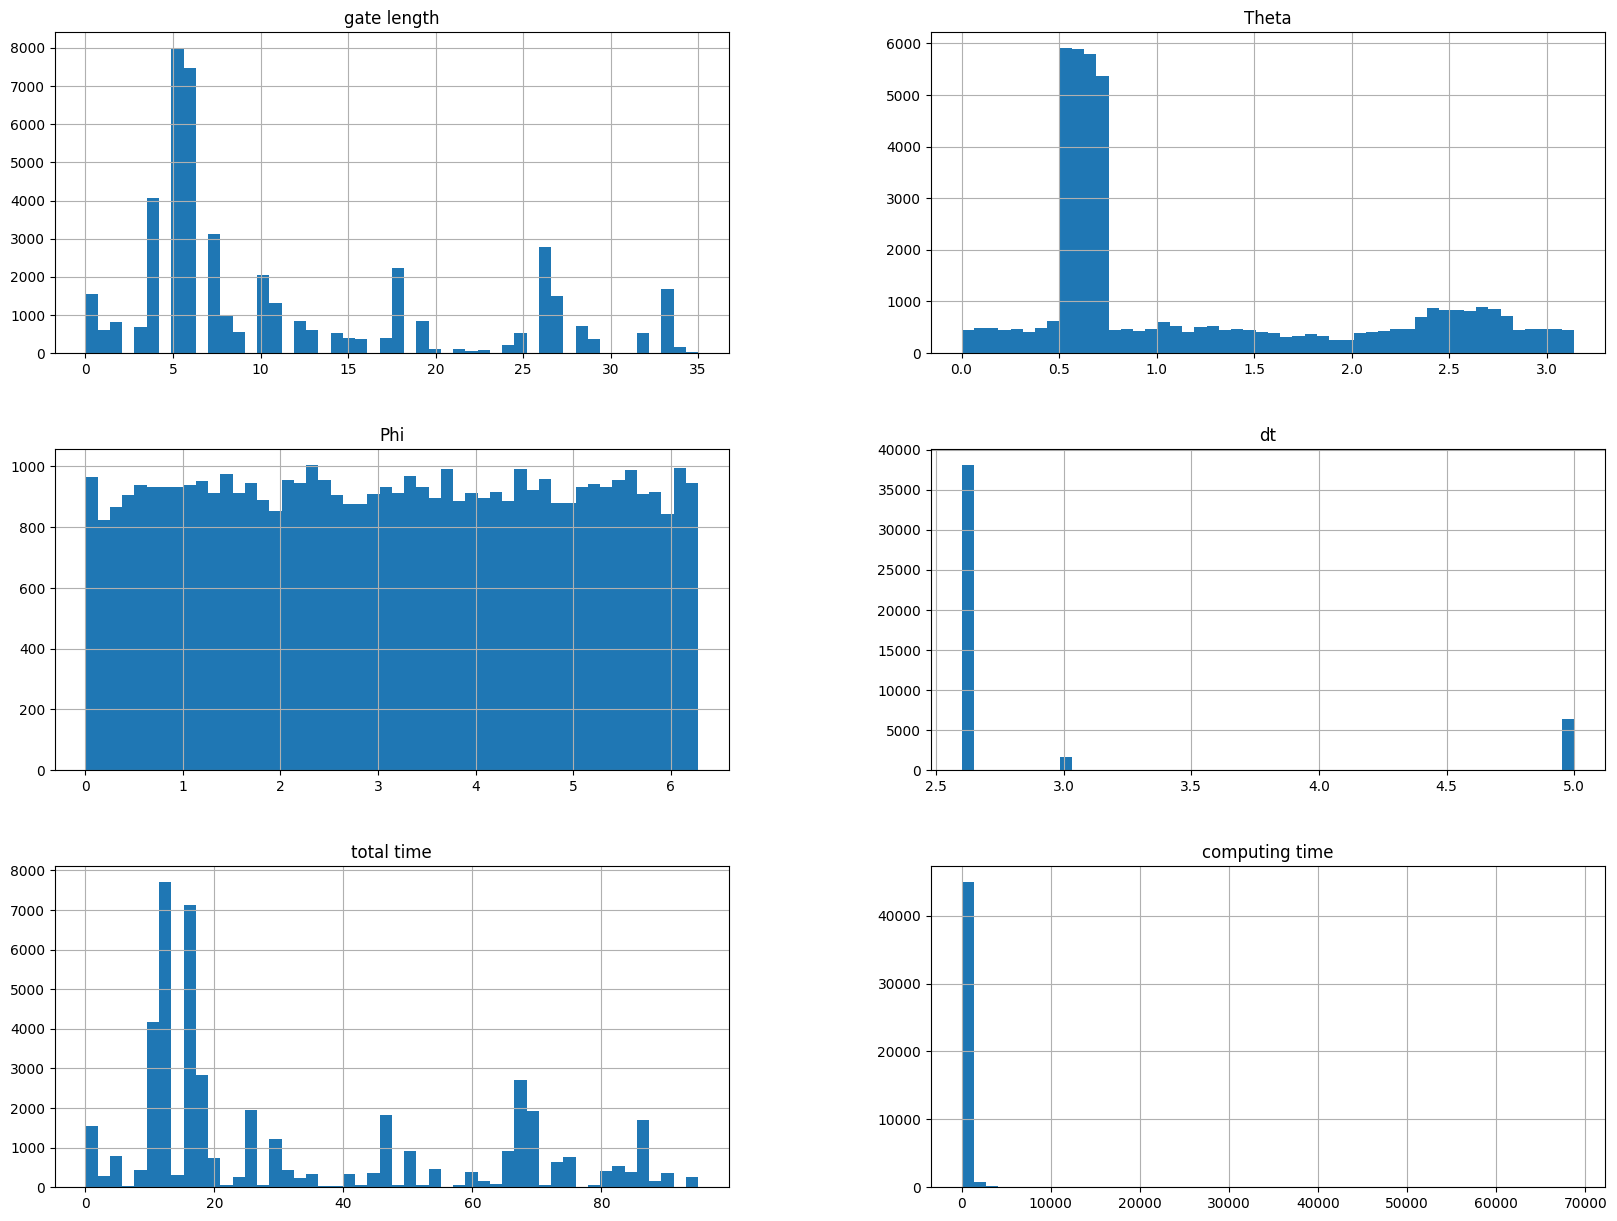

In [14]:
import matplotlib as plt

%matplotlib inline
df.hist(bins=50, figsize=(20,15))

# 히스토그램(주어진 값 범위 수평축, 샘플 수 수직축)

<Axes: xlabel='Theta', ylabel='Phi'>

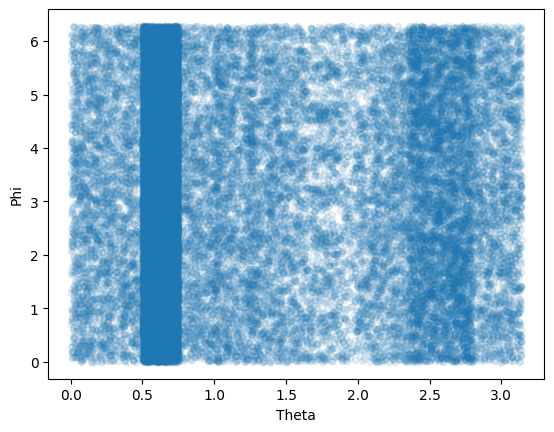

In [16]:
df.plot(kind = "scatter", x="Theta", y="Phi", alpha=0.1)